# Tese Carol - Version with GridSearch and positive/negative ratio 1:2

## Preprocessing

In [106]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

df_neg = pd.read_excel("neg_test5.xlsx")
df_pos = pd.read_excel("pos_test5.xlsx")
print(df_neg.columns)
print(df_pos.columns)


Index(['mut_peptide', 'hla', 'grantham_score', 'mut_in_anchor', 't_cell_type',
       'hydrophobicity', 'polarity', 'score_netmhc', '%rank_netmhc',
       'score_netmhcpan', '%rank_netmhcpan', 'ensemble_score', 'dissimilarity',
       'ctl_tap', 'ctl_cleavage', 'ctl_combined', 'ctl_rank', 'dai',
       'similarity', 'immunogenicity'],
      dtype='object')
Index(['mut_peptide', 'hla', 'grantham_score', 'mut_in_anchor', 't_cell_type',
       'hydrophobicity', 'polarity', 'score_netmhc', '%rank_netmhc',
       'score_netmhcpan', '%rank_netmhcpan', 'ensemble_score', 'dissimilarity',
       'ctl_tap', 'ctl_cleavage', 'ctl_combined', 'ctl_rank', 'dai',
       'similarity', 'immunogenicity'],
      dtype='object')


In [107]:
df_neg = df_neg.drop(columns = "t_cell_type")
df_pos = df_pos.drop(columns = "t_cell_type")
df_neg = df_neg.drop(columns = "hla")
df_pos = df_pos.drop(columns = "hla")
df_neg = df_neg.drop(columns = 'mut_peptide')
df_pos = df_pos.drop(columns = 'mut_peptide')
print(df_neg.columns)

Index(['grantham_score', 'mut_in_anchor', 'hydrophobicity', 'polarity',
       'score_netmhc', '%rank_netmhc', 'score_netmhcpan', '%rank_netmhcpan',
       'ensemble_score', 'dissimilarity', 'ctl_tap', 'ctl_cleavage',
       'ctl_combined', 'ctl_rank', 'dai', 'similarity', 'immunogenicity'],
      dtype='object')


**Size of the datasets**

In [108]:
print(df_neg.shape)
print(df_pos.shape)

(14930, 17)
(294, 17)


**Remove the duplicates**

In [109]:
print(df_neg.shape)
df_neg = df_neg.drop_duplicates()
print(df_neg.shape)
print(df_pos.shape)
df_pos = df_pos.drop_duplicates()
print(df_pos.shape)

(14930, 17)
(14646, 17)
(294, 17)
(294, 17)


**Dealing with the size of both datasets - Sampling the negative data** The negative dataset is much bigger than the positive dataset. Firstly, we will try machine learning using a balanced dataset, which means, the same number of positive and negative examples. To do that we will have to sample the data of the negative dataset. 

OPÇÃO 1: **Undersample majority class** - Under-sample the majority class by randomly picking samples without replacement

In [110]:
from sklearn.utils import resample

df_neg_down = resample(df_neg, replace = False, n_samples = 588, random_state = 21)

print(df_neg_down.shape)
print(df_pos.shape)

(588, 17)
(294, 17)


**Join the positive and negative datasets** - Concatenate the two datasets with the same columns

In [111]:
df_total = pd.concat([df_neg_down,df_pos], ignore_index = True, sort = False)
print(df_total.shape)

(882, 17)


Assign outcome as 0 if immunogenicity in "no" and 1 if "yes"

In [112]:
df_total['immunogenicity'] = [0 if x == "no" else 1 for x in df_total['immunogenicity']]

Assing mut_in_anchor 0 if its "no" and 1 if yes 

In [113]:
df_total['mut_in_anchor'] = [0 if x == "no" else 1 for x in df_total['mut_in_anchor']]

In [114]:
print(df_total.head)
print(df_total.columns)

<bound method NDFrame.head of      grantham_score  mut_in_anchor  hydrophobicity  polarity  score_netmhc  \
0                56              0           16.67      1.93         0.157   
1                21              0           40.11      0.74         0.118   
2                81              0           21.84      0.61         0.097   
3                29              0           39.21      3.22         0.177   
4                43              0           34.14      5.24         0.062   
5                26              0           15.87     49.76         0.331   
6                56              0            2.75    103.56         0.137   
7                24              0           29.01      3.51         0.092   
8               194              1           31.03      5.47         0.117   
9                95              0           14.35    149.43         0.070   
10               64              0           32.58      2.04         0.563   
11              152              0

Assign X as a dataframe of features and y as a series of outcome variables

In [115]:
X = df_total.drop('immunogenicity',1)
y = df_total.immunogenicity

## Dividing the dataset into train and test

In [116]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X,y, train_size = 0.80, random_state = 1)

In [117]:
print(X_train_raw.shape)
print(X_test_raw.shape)
print(y_train.shape)
print(y_test.shape)

(705, 16)
(177, 16)
(705,)
(177,)


## Experiment on handling missing values, scaling and hyperparameter optimization.

### Handling missing data by imputing with KNN

In [118]:
print(X_train_raw.isna().sum().sort_values(ascending = False).head())
print(X_test_raw.isna().sum().sort_values(ascending = False).head())

similarity      339
%rank_netmhc      7
score_netmhc      7
dai               0
ctl_rank          0
dtype: int64
similarity      80
%rank_netmhc     3
score_netmhc     3
dai              0
ctl_rank         0
dtype: int64


In [119]:
print(X_train_raw.dtypes)

grantham_score       int64
mut_in_anchor        int64
hydrophobicity     float64
polarity           float64
score_netmhc       float64
%rank_netmhc       float64
score_netmhcpan    float64
%rank_netmhcpan    float64
ensemble_score     float64
dissimilarity      float64
ctl_tap            float64
ctl_cleavage       float64
ctl_combined       float64
ctl_rank           float64
dai                float64
similarity         float64
dtype: object


In [120]:
from missingpy import KNNImputer
import numpy as np
import warnings
warnings.filterwarnings('ignore')
nan = np.nan
imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train_raw), columns = X_train_raw.columns)
X_test = pd.DataFrame(imputer.transform(X_test_raw),columns = X_test_raw.columns)


In [121]:
print(X_train)

     grantham_score  mut_in_anchor  hydrophobicity  polarity  score_netmhc  \
0              58.0            0.0           22.58     51.46         0.248   
1              27.0            1.0           19.82     51.50         0.061   
2              15.0            0.0           32.97      5.06         0.239   
3              98.0            0.0           29.14      3.29         0.041   
4              99.0            0.0           23.69     54.87         0.250   
5              58.0            0.0           18.36     49.96         0.247   
6             155.0            1.0           39.23      3.84         0.107   
7              46.0            0.0            7.13    104.04         0.293   
8              43.0            0.0           17.46     49.83         0.798   
9              29.0            0.0           18.25     55.36         0.027   
10              0.0            0.0           33.30      5.24         0.405   
11            155.0            1.0           33.61     53.23    

In [122]:
print(X_train.isna().sum().sort_values(ascending = False).head())
print(X_test.isna().sum().sort_values(ascending = False).head())

similarity      0
dai             0
ctl_rank        0
ctl_combined    0
ctl_cleavage    0
dtype: int64
similarity      0
dai             0
ctl_rank        0
ctl_combined    0
ctl_cleavage    0
dtype: int64


### Scaling

**Use StandardScaler for non-binary features**

In [123]:
print(X_train.columns)

Index(['grantham_score', 'mut_in_anchor', 'hydrophobicity', 'polarity',
       'score_netmhc', '%rank_netmhc', 'score_netmhcpan', '%rank_netmhcpan',
       'ensemble_score', 'dissimilarity', 'ctl_tap', 'ctl_cleavage',
       'ctl_combined', 'ctl_rank', 'dai', 'similarity'],
      dtype='object')


In [124]:
from sklearn.preprocessing import StandardScaler 

df_col = X_train.drop(columns = "mut_in_anchor")


scaler = StandardScaler()
X_train[['grantham_score','hydrophobicity','polarity','score_netmhc','%rank_netmhc','score_netmhcpan',
                         '%rank_netmhcpan','ensemble_score','dissimilarity','ctl_tap','ctl_cleavage','ctl_combined','ctl_rank','dai',
                         'similarity']] = pd.DataFrame(scaler.fit_transform(X_train[['grantham_score','hydrophobicity','polarity','score_netmhc','%rank_netmhc','score_netmhcpan',
                         '%rank_netmhcpan','ensemble_score','dissimilarity','ctl_tap','ctl_cleavage','ctl_combined','ctl_rank','dai',
                         'similarity']]), columns = df_col.columns)

X_test[['grantham_score','hydrophobicity','polarity','score_netmhc','%rank_netmhc','score_netmhcpan',
                         '%rank_netmhcpan','ensemble_score','dissimilarity','ctl_tap','ctl_cleavage','ctl_combined','ctl_rank','dai',
                         'similarity']] = pd.DataFrame(scaler.transform(X_test[['grantham_score','hydrophobicity','polarity','score_netmhc','%rank_netmhc','score_netmhcpan',
                         '%rank_netmhcpan','ensemble_score','dissimilarity','ctl_tap','ctl_cleavage','ctl_combined','ctl_rank','dai',
                         'similarity']]), columns = df_col.columns)





In [125]:

print(y_train.shape)

print(X_train.shape)
print(X_train.columns)

(705,)
(705, 16)
Index(['grantham_score', 'mut_in_anchor', 'hydrophobicity', 'polarity',
       'score_netmhc', '%rank_netmhc', 'score_netmhcpan', '%rank_netmhcpan',
       'ensemble_score', 'dissimilarity', 'ctl_tap', 'ctl_cleavage',
       'ctl_combined', 'ctl_rank', 'dai', 'similarity'],
      dtype='object')


## Machine Learning models - Hyperparameter optimization

### Support Vector Machines

Best score:  0.8011394322885819
Best estimator:  SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best params:  {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       114
           1       0.72      0.92      0.81        63

    accuracy                           0.85       177
   macro avg       0.84      0.86      0.84       177
weighted avg       0.87      0.85      0.85       177

Overall Accuracy: 0.847457627118644
CONFUSION MATRIX
[[92 22]
 [ 5 58]]
roc_auc_score:  0.9195210247841827


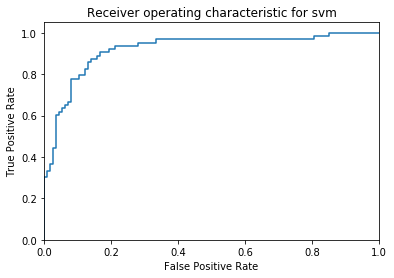

Average precision-recall score: 0.88
F1:  0.8111888111888111
F1beta:  0.8734939759036144


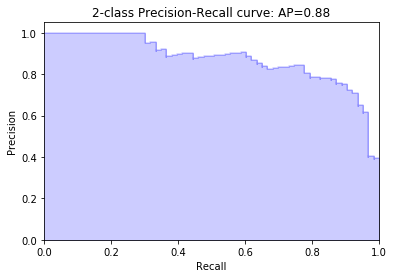

In [42]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer


params_svm = {'kernel': ['linear','rbf','poly','sigmoid'], 'gamma': ['auto',0.001,0.01,0.1],
                     'C': [1,10,15,20], "class_weight": ["balanced",None]}

f1score = make_scorer(f1_score)
model_svm = GridSearchCV(SVC(),params_svm,scoring = f1score, cv = 10,n_jobs = -1)

gs_results_svm = model_svm.fit(X_train, y_train)
y_true, y_pred = y_test, model_svm.predict(X_test)

print("Best score: ",gs_results_svm.best_score_)
print("Best estimator: ",gs_results_svm.best_estimator_)
print("Best params: ",gs_results_svm.best_params_)
print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))


#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

# ROC CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_proba = model_svm.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("roc_auc_score: ", roc_auc_score(y_test, y_proba))

%matplotlib inline 

plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for svm')
plt.show()

#PR CURVE

# compute the average precision score

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))

y_proba1 = y_proba
y_test1 = y_test

precision1 = precision
recall1 = recall


### K-Nearest Neighbors

Best score:  0.7589875350685754
Best estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
Best params:  {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       114
           1       0.81      0.86      0.83        63

    accuracy                           0.88       177
   macro avg       0.86      0.87      0.87       177
weighted avg       0.88      0.88      0.88       177

Overall Accuracy: 0.8757062146892656
CONFUSION MATRIX
[[101  13]
 [  9  54]]
roc_auc_score:  0.9358813700918965


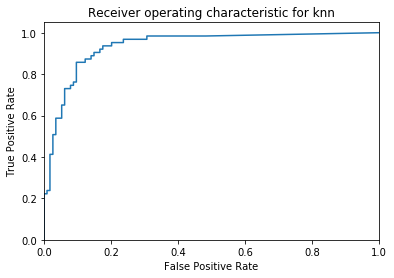

Average precision-recall score: 0.88
F1:  0.8307692307692308
F1beta:  0.8463949843260187


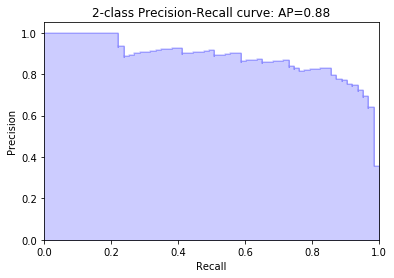

In [63]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np
from random import randint
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

params_knn = {'n_neighbors': [3,5,11,10],
              'weights':['uniform','distance'],
              'metric':['euclidean','manhattan'] }

f1score = make_scorer(f1_score)
model_knn = GridSearchCV(KNeighborsClassifier(),params_knn, scoring = f1score, cv = 10, n_jobs = -1)

gs_results_knn = model_knn.fit(X_train, y_train)
y_true, y_pred = y_test, model_knn.predict(X_test)

print("Best score: ",gs_results_knn.best_score_)
print("Best estimator: ",gs_results_knn.best_estimator_)
print("Best params: ",gs_results_knn.best_params_)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))


#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

#ROC CURVE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_proba = model_knn.predict_proba(X_test)[:,1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("roc_auc_score: ", roc_auc_score(y_test, y_proba))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for knn')
plt.show()


#PR CURVE

# compute the average precision score

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))



print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))

y_proba2 = y_proba
y_test2 = y_test

precision2 = precision
recall2 = recall


### Logistic Regression

Best score:  0.7840834651784601
Best estimator:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Best params:  {'C': 0.01, 'penalty': 'l1'}
Classification report: 
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       114
           1       0.72      0.89      0.79        63

    accuracy                           0.84       177
   macro avg       0.82      0.85      0.83       177
weighted avg       0.85      0.84      0.84       177

Overall Accuracy: 0.8361581920903954
CONFUSION MATRIX
[[92 22]
 [ 7 56]]
roc_auc_score:  0.9153439153439153


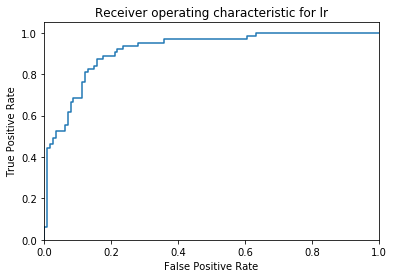

Average precision-recall score: 0.85
F1:  0.7943262411347517
F1beta:  0.8484848484848485


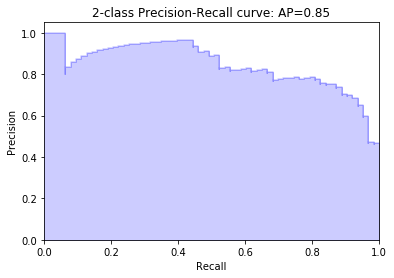

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score


params = {'penalty': ["l1","l2"], 'C': np.logspace(-3,3,7)}

f1score = make_scorer(f1_score)
model_lr = GridSearchCV(LogisticRegression(), params, scoring = f1score, cv=10, n_jobs = -1)

gs_results_lr = model_lr.fit(X_train,y_train)
y_true, y_pred = y_test, model_lr.predict(X_test)

print("Best score: ",gs_results_lr.best_score_)
print("Best estimator: ",gs_results_lr.best_estimator_)
print("Best params: ",gs_results_lr.best_params_)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))


#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))


#ROC CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_proba = model_lr.predict_proba(X_test)[:,1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("roc_auc_score: ",roc_auc_score(y_test, y_proba))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for lr')
plt.show()

#PR CURVE

# compute the average precision score

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))

y_proba3 = y_proba
y_test3 = y_test

precision3 = precision
recall3 = recall



### Random Forests

Best score:  0.8229358716453999
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best params:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 20}
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       114
           1       0.81      0.89      0.85        63

    accuracy                           0.89       177
   macro avg       0.87      0.89      0.88       177
weighted a

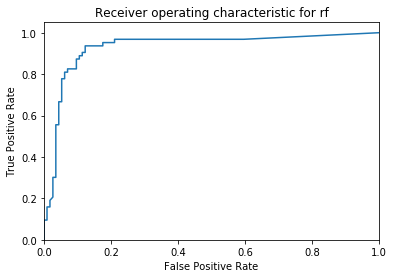

Average precision-recall score: 0.86
F1:  0.8484848484848485
F1beta:  0.8722741433021806


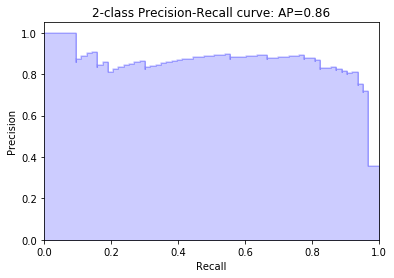

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
from random import randint
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

params_rf = {"n_estimators": [20,40,60,80,100], "max_features": ["auto",2,3,6,10], "min_samples_split": [2,3,6,10], "min_samples_leaf": [2,3,6,10], "max_depth":[2,3,None], "bootstrap": [True,False],"criterion":["gini","entropy"] }

f1score = make_scorer(f1_score)
model_rf = GridSearchCV(RandomForestClassifier(), params_rf, scoring = f1score, cv=10, n_jobs = -1)

gs_results_rf = model_rf.fit(X_train,y_train)
y_true, y_pred = y_test, model_rf.predict(X_test)

print("Best score: ",gs_results_rf.best_score_)
print("Best estimator: ",gs_results_rf.best_estimator_)
print("Best params: ",gs_results_rf.best_params_)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))


#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

#ROC CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_proba = model_rf.predict_proba(X_test)[:,1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("roc_auc_score: ",roc_auc_score(y_test, y_proba))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for rf')
plt.show()

#PR CURVE

# compute the average precision score

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))

y_proba4 = y_proba
y_test4 = y_test

precision4 = precision
recall4 = recall



# Overlap ROC curves

roc_auc_score SVM:  0.9195210247841827
roc_auc_score KNN:  0.9358813700918965
roc_auc_score LR:  0.9153439153439153
roc_auc_score RF:  0.92989417989418


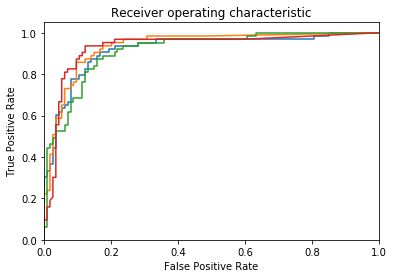

In [127]:
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
for i in range(2):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test1, y_proba1)
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

fpr_knn = dict()
tpr_knn= dict()
roc_auc_knn = dict()
for i in range(2):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test2, y_proba2)
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    
fpr_lr = dict()
tpr_lr= dict()
roc_auc_lr = dict()
for i in range(2):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test3, y_proba3)
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])
    
fpr_rf = dict()
tpr_rf= dict()
roc_auc_rf = dict()
for i in range(2):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test4, y_proba4)
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

    
print("roc_auc_score SVM: ",roc_auc_score(y_test1, y_proba1))
print("roc_auc_score KNN: ",roc_auc_score(y_test2, y_proba2))
print("roc_auc_score LR: ",roc_auc_score(y_test3, y_proba3))
print("roc_auc_score RF: ",roc_auc_score(y_test4, y_proba4))

%matplotlib inline
plt.figure()
plt.plot(fpr_svm[1], tpr_svm[1])
plt.plot(fpr_knn[1], tpr_knn[1])
plt.plot(fpr_lr[1], tpr_lr[1])
plt.plot(fpr_rf[1], tpr_rf[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

# Overlap PR curves

Average precision-recall score SVM: 0.88
Average precision-recall score KNN: 0.88
Average precision-recall score LR: 0.85
Average precision-recall score RF: 0.86


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.86')

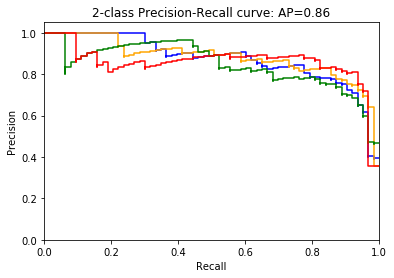

In [128]:
from sklearn.metrics import average_precision_score
average_precision_svm = average_precision_score(y_test1, y_proba1)

print('Average precision-recall score SVM: {0:0.2f}'.format(
      average_precision_svm))

average_precision_knn = average_precision_score(y_test2, y_proba2)

print('Average precision-recall score KNN: {0:0.2f}'.format(
      average_precision_knn))


average_precision_lr = average_precision_score(y_test3, y_proba3)

print('Average precision-recall score LR: {0:0.2f}'.format(
      average_precision_lr))

average_precision_rf = average_precision_score(y_test4, y_proba4)

print('Average precision-recall score RF: {0:0.2f}'.format(
      average_precision_rf))


#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

plt.step(recall1, precision1, color='blue',
         where='post')


plt.step(recall2, precision2, color='orange', 
         where='post')

plt.step(recall3, precision3, color='green', 
         where='post')

plt.step(recall4, precision4, color='red', 
         where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))